In [725]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from jupyterthemes import jtplot
jtplot.style()

from wrangle import wrangle_zillow, split_zillow
from scale_and_featureeng import select_kbest, rfe, scale_data

import explore

plt.rcParams['figure.figsize'] = (8,4)

# Analyzing and predicting tax_value
## Key findings:
- 70% of single unit homes sold from May-Aug 2017 were in LA county
- 44% are 2 bed 2 bath
- #1 driver of tax_value is square footage, # of bed/bathrooms, and age of the home are important as well
- Not enough data to produce a reliable regression model


# Data acquisition and prep
- Data acquired from zillow sql database
- Single unit count properties selected as well as propertylandusetypeid 261(Single Family Residential), 279(Inferred single family residential), 262(Rural residence), 263(Mobile home), 264(Town house), 266(Condominium), 275(manufactured, modular, prefabricated homes) for better distribution between 3 counties. Each can still be considered to be bought/rented as a single entity.
- Nulls dropped, categorical columns created for bedrooms/bathrooms, house age_in_years feature created using yearbuilt tax_rate feature created using taxvaluedollarcnt and taxes
- Outliers handled by implementing 1.5* IQR for upper and lower bounds
- End result is a dataframe with 32737 records and 15 columns but not all were used for regression model

In [726]:
zillow = wrangle_zillow()
zillow.head()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,lotsizesquarefeet,regionidzip,tax_value,taxes,transactiondate,age_in_years,Bathrooms_cat,Bedrooms_cat,tax_rate
parcelid,,,,,,,,,,,,,,,
11721753,2.0,3.0,1316.0,6037.0,34033180.0,-118355396.0,5672.0,95997.0,205123.0,2627.48,2017-07-21,98.0,2,2,1.28
11289917,2.0,3.0,1458.0,6037.0,34686163.0,-118113100.0,8284.0,97318.0,136104.0,2319.90,2017-06-23,51.0,2,2,1.70
11637029,2.0,3.0,1766.0,6037.0,34073222.0,-118390965.0,25082.0,96086.0,810694.0,9407.01,2017-07-28,41.0,2,2,1.16
11705026,1.0,2.0,1421.0,6037.0,33999877.0,-118291863.0,6707.0,96018.0,35606.0,543.69,2017-06-30,110.0,1,1,1.53
14269464,3.0,4.0,2541.0,6059.0,33694636.0,-117912245.0,4975.0,96958.0,880456.0,9819.72,2017-06-01,18.0,3,3,1.12


In [727]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32737 entries, 11721753 to 10713993
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathrooms          32737 non-null  float64
 1   bedrooms           32737 non-null  float64
 2   square_feet        32737 non-null  float64
 3   fips               32737 non-null  float64
 4   latitude           32737 non-null  float64
 5   longitude          32737 non-null  float64
 6   lotsizesquarefeet  32737 non-null  float64
 7   regionidzip        32737 non-null  float64
 8   tax_value          32737 non-null  float64
 9   taxes              32737 non-null  float64
 10  transactiondate    32737 non-null  object 
 11  age_in_years       32737 non-null  float64
 12  Bathrooms_cat      32737 non-null  object 
 13  Bedrooms_cat       32737 non-null  object 
 14  tax_rate           32737 non-null  float64
dtypes: float64(12), object(3)
memory usage: 4.0+ MB


## Exploration

In [728]:
# splitting columns between categorical and quantitative for explore functions
cat_vars = ['fips', 'Bedrooms_cat', 'Bathrooms_cat']

quant_vars = ['square_feet',                         
              'lotsizesquarefeet',              
              'tax_value',
              'taxes',              
              'age_in_years',
              'tax_rate'
              ]

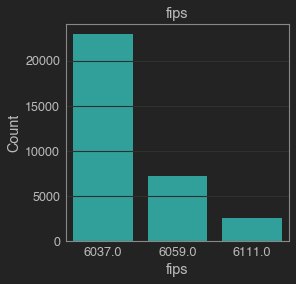

          fips  Count  Percent
6037.0  6037.0  22927    70.03
6059.0  6059.0   7221    22.06
6111.0  6111.0   2589     7.91
_________________________________________________________________


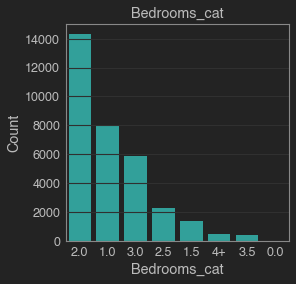

    Bedrooms_cat  Count  Percent
2.0            2  14311    43.72
3.0            1   7978    24.37
1.0            3   5885    17.98
2.5          2.5   2276     6.95
4+           1.5   1372     4.19
1.5           4+    479     1.46
3.5          3.5    396     1.21
0.0            0     40     0.12
_________________________________________________________________


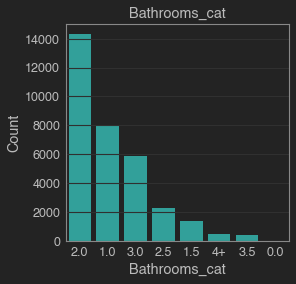

    Bathrooms_cat  Count  Percent
2.0             2  14311    43.72
3.0             1   7978    24.37
1.0             3   5885    17.98
2.5           2.5   2276     6.95
4+            1.5   1372     4.19
1.5            4+    479     1.46
3.5           3.5    396     1.21
0.0             0     40     0.12
_________________________________________________________________


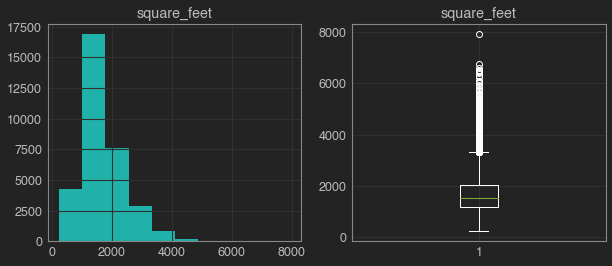

count    32737.000000
mean      1691.697926
std        716.465814
min        240.000000
25%       1189.000000
50%       1528.000000
75%       2039.000000
max       7942.000000
Name: square_feet, dtype: float64


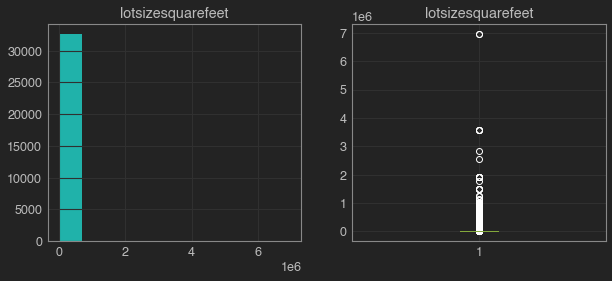

count    3.273700e+04
mean     3.040644e+04
std      1.138988e+05
min      2.360000e+02
25%      5.712000e+03
50%      7.200000e+03
75%      1.150000e+04
max      6.971010e+06
Name: lotsizesquarefeet, dtype: float64


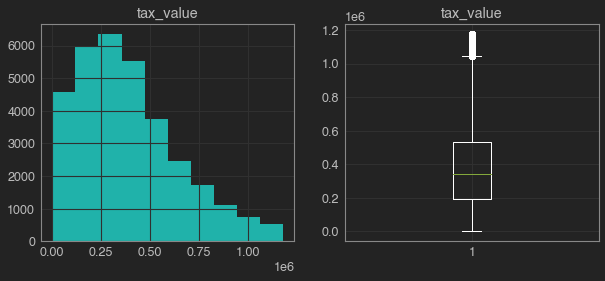

count    3.273700e+04
mean     3.895280e+05
std      2.533097e+05
min      1.000000e+03
25%      1.945800e+05
50%      3.441140e+05
75%      5.336390e+05
max      1.178048e+06
Name: tax_value, dtype: float64


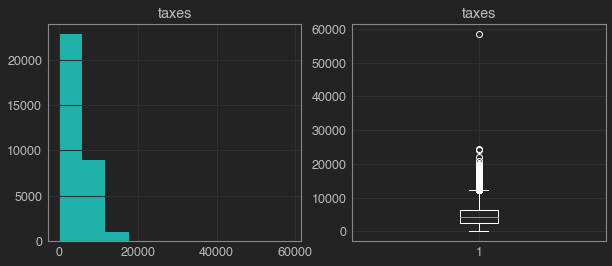

count    32737.000000
mean      4835.386009
std       2994.294512
min         19.920000
25%       2605.250000
50%       4306.820000
75%       6445.660000
max      58634.770000
Name: taxes, dtype: float64


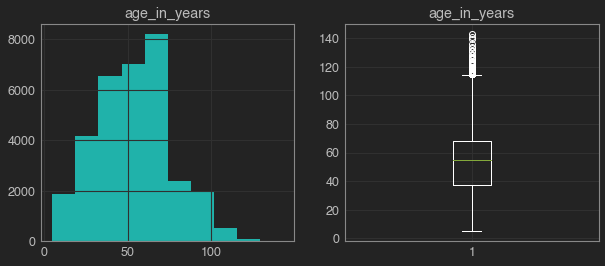

count    32737.000000
mean        54.006842
std         22.200494
min          5.000000
25%         37.000000
50%         55.000000
75%         68.000000
max        143.000000
Name: age_in_years, dtype: float64


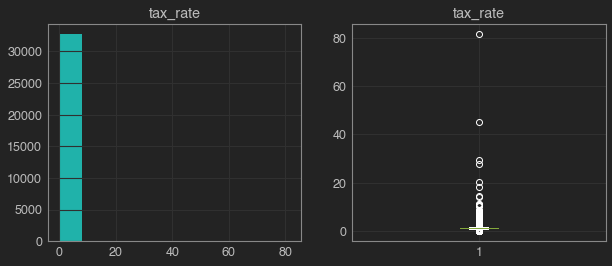

count    32737.000000
mean         1.330349
std          0.681460
min          0.010000
25%          1.180000
50%          1.230000
75%          1.360000
max         81.650000
Name: tax_rate, dtype: float64


In [729]:
#explore.py function to visualize single category data distributions
explore.explore_univariate(zillow, cat_vars, quant_vars)

# Tax rate distribution for LA county

<AxesSubplot:title={'center':'LA county tax rate distribution'}, xlabel='tax_rate', ylabel='Density'>

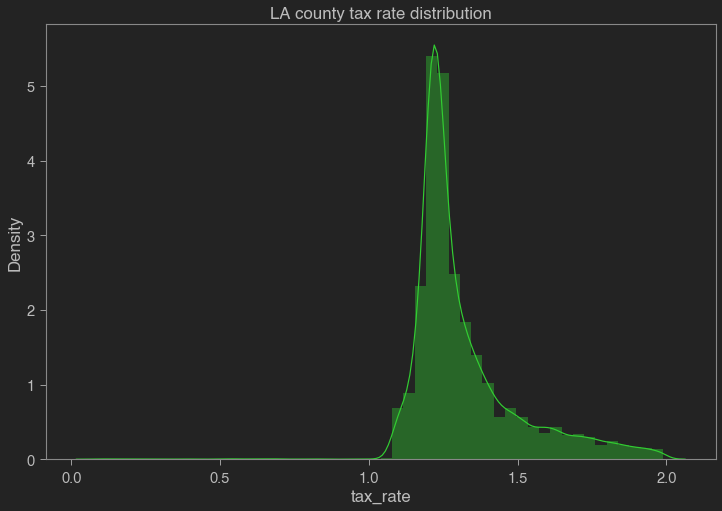

In [730]:
jtplot.style(grid=False, theme='monokai', fscale=1.4, ticks=True)
plt.figure(figsize=(12,8))
plt.title('LA county tax rate distribution')
sns.distplot(zillow[(zillow.fips == 6037)&(zillow.tax_rate < 2)].tax_rate, color='limegreen')

In [731]:
# mean tax_rate LA county
zillow[zillow.fips == 6037].tax_rate.mean()

1.384269202250612

# Tax rate distribution for Orange county

<AxesSubplot:title={'center':'Orange county tax rate distribution'}, xlabel='tax_rate', ylabel='Density'>

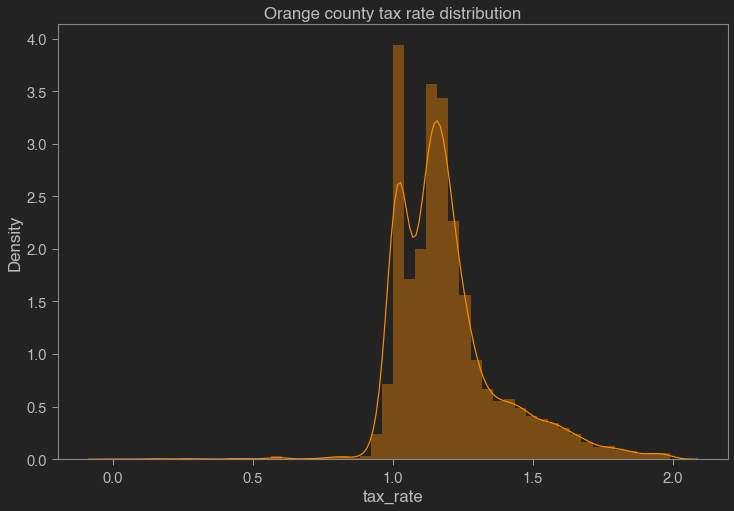

In [732]:
#'oceans16', 'grade3', 'chesterish', 'onedork', 'monokai', 'solarizedl', 'solarizedd'. 
# jtplot.style()
plt.figure(figsize=(12,8))
plt.title('Orange county tax rate distribution')
sns.distplot(zillow[(zillow.fips == 6059)&(zillow.tax_rate < 2)].tax_rate, color='darkorange')

In [733]:
#mean tax_rate Orange county
zillow[zillow.fips == 6059].tax_rate.mean()

1.2116244287494904

# Tax rate distribution for Ventura county

<AxesSubplot:title={'center':'Ventura county tax rate distribution'}, xlabel='tax_rate', ylabel='Density'>

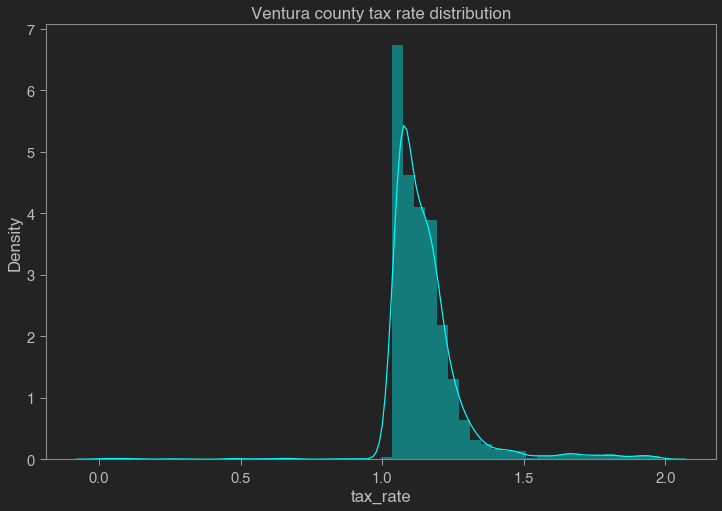

In [734]:
plt.figure(figsize=(12,8))
plt.title('Ventura county tax rate distribution')
sns.distplot(zillow[(zillow.fips == 6111)&(zillow.tax_rate < 2)].tax_rate, color='cyan')

In [735]:
zillow[zillow.fips == 6111].tax_rate.mean()

1.183993820007725

##### Univariate Takeaways
- 70% of single unit properties are in LA county (6037)
- median home age is 55 years
- median square footage is 1528 sqft
- median tax value is $344,114.0

In [736]:
#split
train, validate, test = split_zillow(zillow)

fips 
_____________________

          chi2       p-value  degrees of freedom
0  39478.75889  1.497634e-33               36152

observed:
 tax_value  1000.0  11683.0  14284.0  14439.0  15692.0  16084.0  16305.0  \
fips                                                                      
6037.0          1        1        1        1        1        1        1   
6059.0          0        0        0        0        0        0        0   
6111.0          0        0        0        0        0        0        0   
All             1        1        1        1        1        1        1   

tax_value  16514.0  16722.0  16723.0  ...  1177141.0  1177308.0  1177488.0  \
fips                                  ...                                    
6037.0           1        1        1  ...          0          0          1   
6059.0           0        0        0  ...          1          1          0   
6111.0           0        0        0  ...          0          0          0   
All              1  

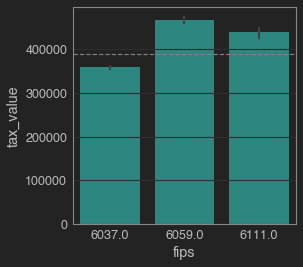


_____________________

Bedrooms_cat 
_____________________

            chi2       p-value  degrees of freedom
0  133050.634065  1.697372e-37              126532

observed:
 tax_value     1000.0  11683.0  14284.0  14439.0  15692.0  16084.0  16305.0  \
Bedrooms_cat                                                                 
0.0                0        0        0        0        0        0        0   
1.0                0        1        1        1        1        1        1   
1.5                0        0        0        0        0        0        0   
2.0                0        0        0        0        0        0        0   
2.5                0        0        0        0        0        0        0   
3.0                0        0        0        0        0        0        0   
3.5                0        0        0        0        0        0        0   
4+                 1        0        0        0        0        0        0   
All                1        1        1       

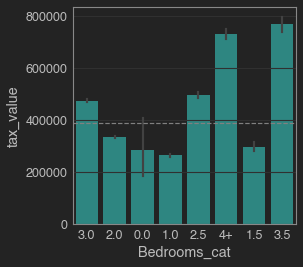


_____________________

Bathrooms_cat 
_____________________

            chi2       p-value  degrees of freedom
0  133050.634065  1.697372e-37              126532

observed:
 tax_value      1000.0  11683.0  14284.0  14439.0  15692.0  16084.0  16305.0  \
Bathrooms_cat                                                                 
0.0                 0        0        0        0        0        0        0   
1.0                 0        1        1        1        1        1        1   
1.5                 0        0        0        0        0        0        0   
2.0                 0        0        0        0        0        0        0   
2.5                 0        0        0        0        0        0        0   
3.0                 0        0        0        0        0        0        0   
3.5                 0        0        0        0        0        0        0   
4+                  1        0        0        0        0        0        0   
All                 1        1    

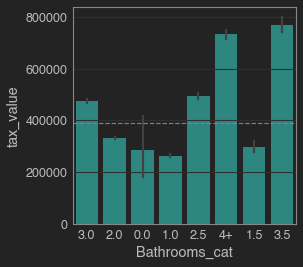


_____________________

  
____________________



KeyError: 'Column not found:  '

In [10]:
# explore function to compare variables to the target of 'tax_value'
# Quant vars excluded from this function due to process time limitations
explore.explore_bivariate(train, 'tax_value', cat_vars, ' ' )

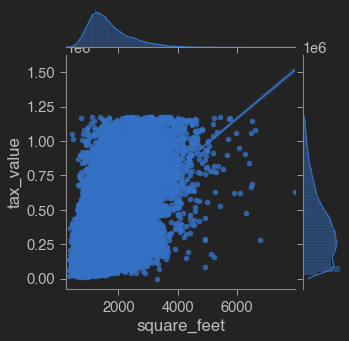

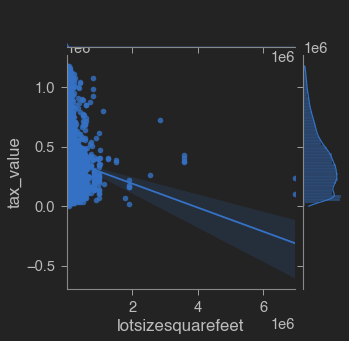

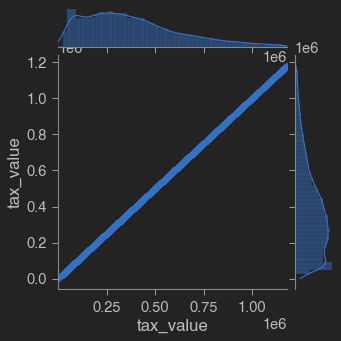

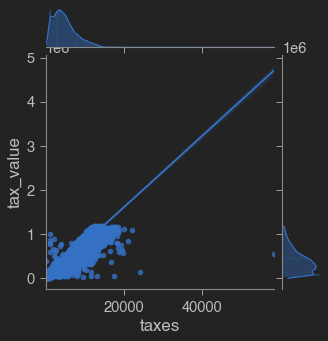

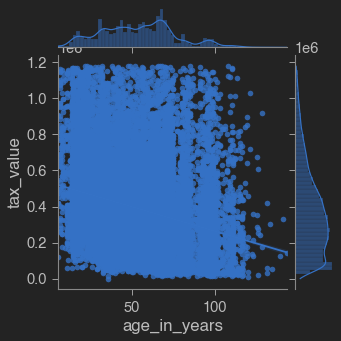

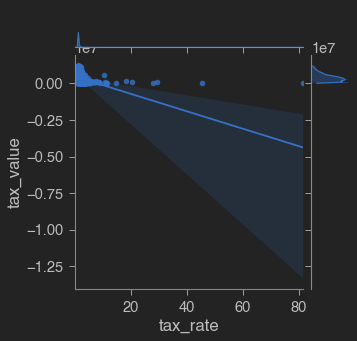

In [737]:
# Joint plots for quantitative varibles vs tax_value
for col in quant_vars:
    sns.jointplot(col, "tax_value", data=train, kind='reg', height=5);
    plt.show()

<AxesSubplot:xlabel='Bedrooms_cat', ylabel='tax_value'>

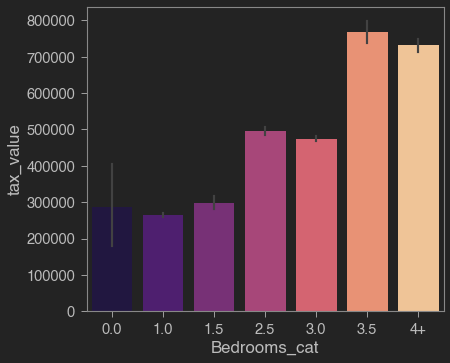

In [738]:
# bedroom categories vs tax_value
sns.barplot(data=train, x='Bedrooms_cat',y='tax_value', palette='magma', order=[0.0,1.0,1.5,2.5,3.0,3.5,'4+']) 

<AxesSubplot:xlabel='Bathrooms_cat', ylabel='tax_value'>

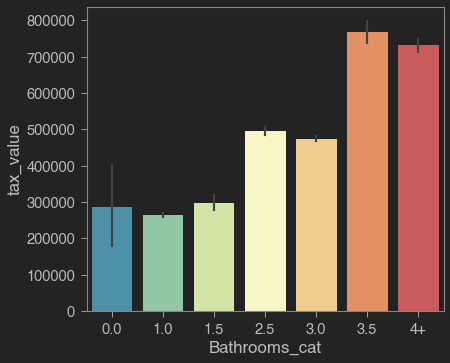

In [739]:
# bathroom categories vs tax_value
sns.barplot(data=train, x='Bathrooms_cat',y='tax_value', palette='Spectral_r', order=[0.0,1.0,1.5,2.5,3.0,3.5,'4+']) 

<AxesSubplot:xlabel='Bathrooms_cat', ylabel='square_feet'>

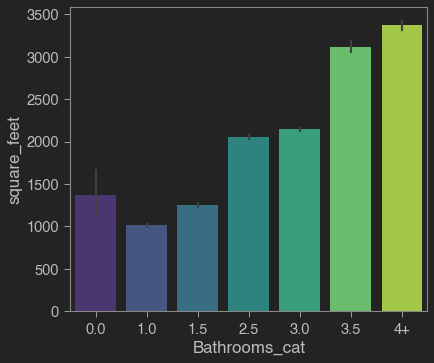

In [740]:
# bathroom categories vs square_feet
sns.barplot(data=train, x='Bathrooms_cat',y='square_feet', palette='viridis', order=[0.0,1.0,1.5,2.5,3.0,3.5,'4+']) 

In [741]:
plot_vars = ['bedrooms',
             'bathrooms',
             'square_feet',
             'lotsizesquarefeet',
             'tax_value',
             'taxes',
             'age_in_years',
             'tax_rate']

<AxesSubplot:>

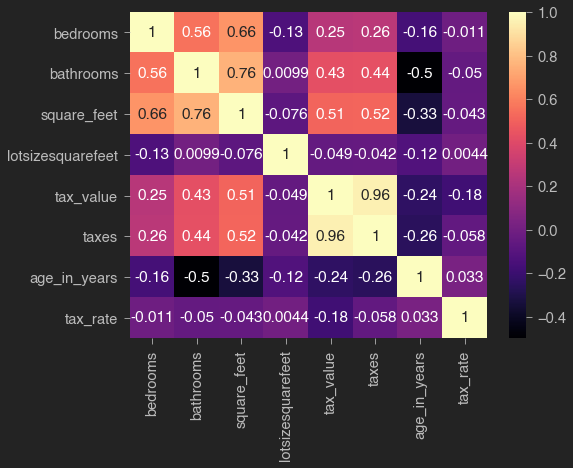

In [742]:
# correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(train[plot_vars].corr(), cmap='magma', annot=True)

##### Bivariate Takeaways
- The highest tax values are in Orange county (6059)
- Tax value increases significantly with more than 3 bedrooms and bathrooms
- Square footage has a positive correlation with tax value

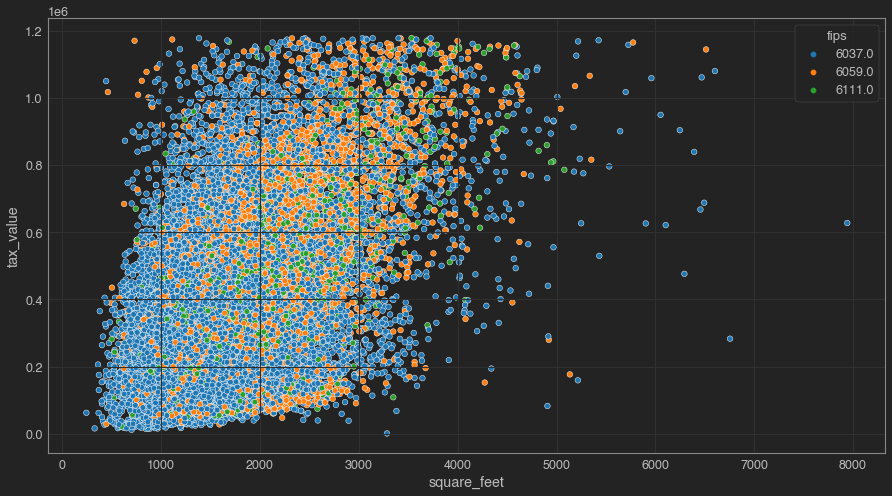

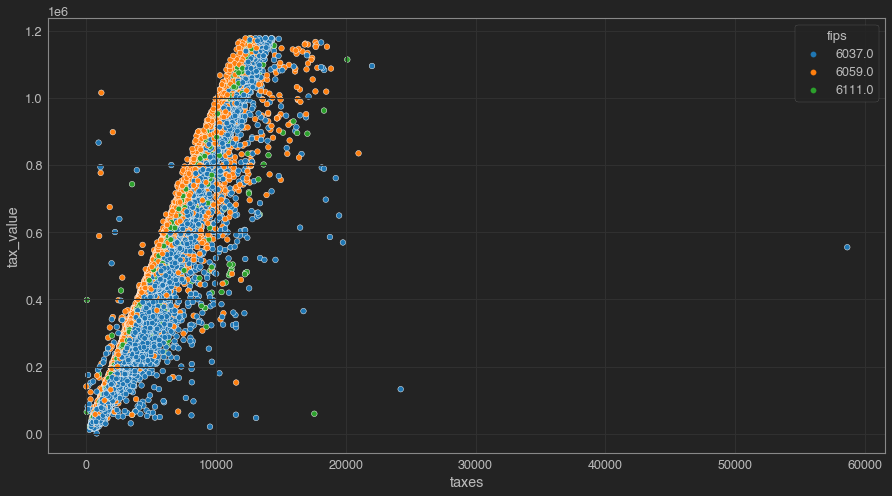

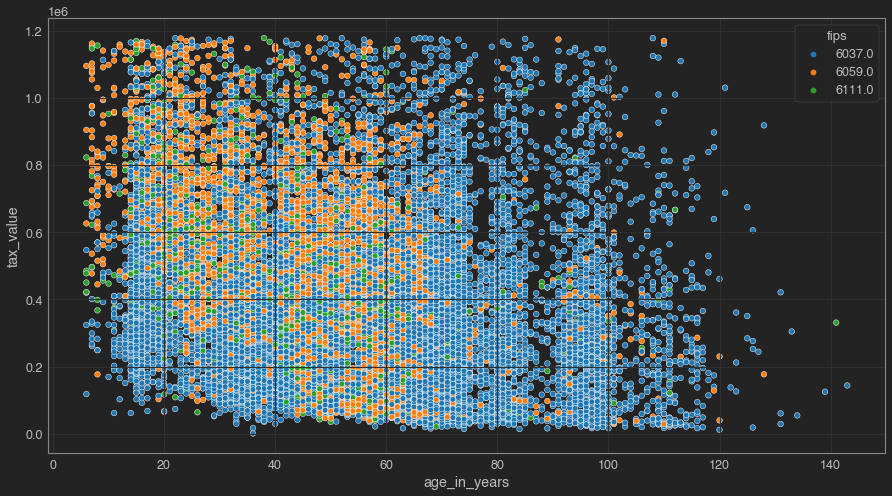

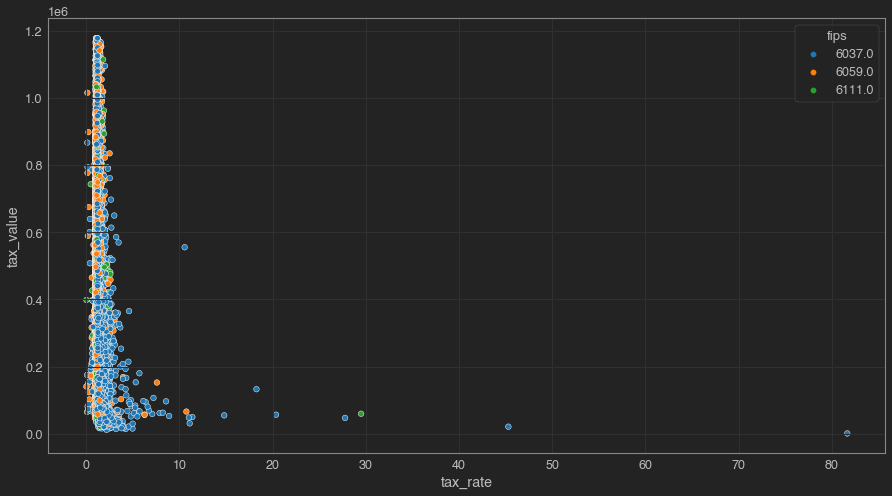

In [706]:
# Multivariate exploration
# This cell compares two categories and separates counties(fips) by hue
jtplot.style()
plot_vars = ['square_feet','taxes','age_in_years','tax_rate']
for col in plot_vars:
    plt.figure(figsize=(15,8))
    sns.scatterplot(col,'tax_value',hue='fips',data=train,palette='tab10')

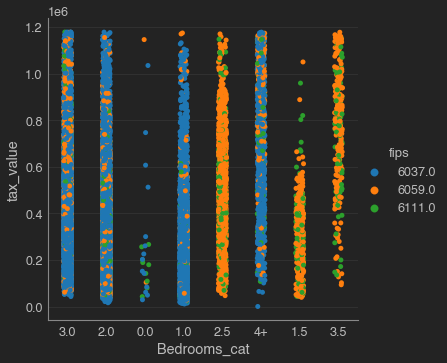

In [110]:
# bedroom categorical plots separated by county
sns.catplot(hue='fips',x='Bedrooms_cat',y='tax_value',data=train, palette='tab10')

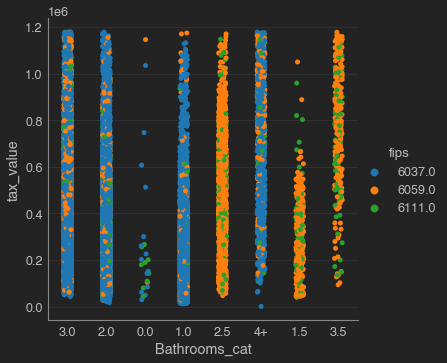

In [111]:
# bathroom categorical plot separated by county
sns.catplot(hue='fips',x='Bathrooms_cat',y='tax_value',data=train, palette='tab10')

##### Multivariate Takeaways
- LA county has most of the older homes (age 60+ years)
- Looks to be a slight negative correlation between age and tax value
- Orange county dominates the 1.5,2.5, and 3.5 bed/bath categories while LA county dominates 1,2,3,and 4+ bed/bath

### 1. Is the mean tax value significantly different between LA and other counties?

In [743]:
null_hypothesis = "The mean tax values are the same between counties"
alternative_hypothesis = "The mean tax values are significantly different between counties"
confidence_level = .95
a = 1 - confidence_level 

In [744]:
#subsetting counties from train data
LA = train[train.fips == 6037]
Ventura_Orange = train[train.fips != 6037]

In [745]:
#two tailed two sample t-test for independence
t, p = stats.ttest_ind(LA.tax_value, Ventura_Orange.tax_value)
t, p

(-27.898434829922593, 1.8178925125905907e-168)

In [746]:
if p < a:
    print('We reject the null')
else:
    print("we fail to reject the null")

We reject the null


In [747]:
print('The mean tax_values for LA county is significantly different than Ventura and Orange counties')

The mean tax_values for LA county is significantly different than Ventura and Orange counties


In [748]:
# verification
# Ventura + Orange county tax value mean is about $100k higher than LA
LA.tax_value.mean(), Ventura_Orange.tax_value.mean()

(358903.67186626064, 459546.66896248533)

In [749]:
# checking medians
# Ventura + Orange county tax value medians are ~$120k higher than LA 
LA.tax_value.median(), Ventura_Orange.tax_value.median()

(309820.0, 431326.0)

### 2. Is there a correlation between home age and tax_value?

In [750]:
null_hypothesis = "There is no correlation between home age and tax_value"
alternative_hypothesis = "There is a negative correlation between home age and tax value"
confidence_level = .95
a = 1 - confidence_level

In [751]:
#Pearson correlation test between two continuous variables
r, p = stats.pearsonr(train.age_in_years, train.tax_value)
r, p

(-0.23880765398020834, 1.524836882919844e-294)

In [752]:
if p < a:
    print('We reject the null')
else:
    print("we fail to reject the null")

We reject the null


In [753]:
print('There is weak negative correlation between home age and tax value')

There is weak negative correlation between home age and tax value


### 3. Is there a correlation between square_feet and tax value?

In [754]:
null_hypothesis = "There is no correlation between square_feet and tax_value"
alternative_hypothesis = "There is a positive correlation between square_feet and tax_value"
confidence_level = .95
a = 1 - confidence_level

#Pearson correlation test between two continuous variables
r, p = stats.pearsonr(train.square_feet, train.tax_value)
r, p

(0.5125372690565347, 0.0)

In [755]:
if p < a:
    print('We reject the null')
else:
    print("we fail to reject the null")
    
print('Pearson correlation = ', r)
print('There is a moderate positive correlation between square_feet and tax_value')

We reject the null
Pearson correlation =  0.5125372690565347
There is a moderate positive correlation between square_feet and tax_value


# Modeling and Evaluation
- Creating multiple regression models using mostly default settings then choosing the best performing

In [756]:
#MVP features
features = ['bedrooms','bathrooms','square_feet']

X_train_mvp = train[features]
y_train_mvp = train.tax_value

X_validate_mvp = validate[features]
y_validate_mvp = validate.tax_value

X_test_mvp = test[features]
y_test_mvp = test.tax_value

In [757]:
# scaling data
X_train_scaled_mvp, X_validate_scaled_mvp, X_test_scaled_mvp = scale_data(X_train_mvp, X_validate_mvp, X_test_mvp)

In [758]:
#verifying scale
X_train_scaled_mvp.head()

,bedrooms,bathrooms,square_feet
0,0.181818,0.3,0.164156
1,0.363636,0.2,0.201299
2,0.363636,0.2,0.172208
3,0.363636,0.3,0.340000
4,0.363636,0.2,0.221558


# Baseline (MVP)

In [759]:
y_train_mvp = pd.DataFrame(y_train_mvp)
y_validate_mvp = pd.DataFrame(y_validate_mvp)

# 1. Predict pred_mean
tax_pred_mean = y_train_mvp.tax_value.mean()
y_train_mvp['tax_pred_mean'] = tax_pred_mean
y_validate_mvp['tax_pred_mean'] = tax_pred_mean

# 2. compute pred_median
tax_pred_median = y_train_mvp.tax_value.median()
y_train_mvp['tax_pred_median'] = tax_pred_median
y_validate_mvp['tax_pred_median'] = tax_pred_median

In [760]:
#baseline target df
y_train_mvp.head()

,tax_value,tax_pred_mean,tax_pred_median
parcelid,,,
10910564,640000.0,388874.774296,342000.0
12484604,390739.0,388874.774296,342000.0
10715844,392582.0,388874.774296,342000.0
14200142,535012.0,388874.774296,342000.0
12575258,499502.0,388874.774296,342000.0


In [761]:
# 3. RMSE of pred_mean
rmse_train = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of pred_median
rmse_train = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  253915.69 
Validate/Out-of-Sample:  251880.24
RMSE using Median
Train/In-Sample:  258206.16 
Validate/Out-of-Sample:  256602.85


# OLS (MVP)

In [762]:
lm = LinearRegression(normalize=False)

lm.fit(X_train_scaled_mvp, y_train_mvp.tax_value)

y_train_mvp['tax_pred_lm'] = lm.predict(X_train_scaled_mvp)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_pred_lm) ** (1/2)

# predict validate
y_validate_mvp['tax_pred_lm'] = lm.predict(X_validate_scaled_mvp)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  215186.06648001247 
Validation/Out-of-Sample:  215230.98611942664


In [763]:
# R2 for train
explained_variance_score(y_train_mvp.tax_value, y_train_mvp.tax_pred_lm)

0.2817936981346598

In [764]:
# R2 for validate
explained_variance_score(y_validate_mvp.tax_value, y_validate_mvp.tax_pred_lm)

0.27020461716946587

# LassoLars (MVP)

In [765]:
lars = LassoLars(alpha=1)

lars.fit(X_train_scaled_mvp, y_train_mvp.tax_value)

# predict train
y_train_mvp['tax_pred_lars'] = lars.predict(X_train_scaled_mvp)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_pred_lars) ** (1/2)

# predict validate
y_validate_mvp['tax_pred_lars'] = lars.predict(X_validate_scaled_mvp)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  215186.4041776229 
Validation/Out-of-Sample:  215229.35761121477


In [766]:
# R2 train
explained_variance_score(y_train_mvp.tax_value, y_train_mvp.tax_pred_lars)

0.2817914439297643

In [767]:
# R2 validate
explained_variance_score(y_validate_mvp.tax_value, y_validate_mvp.tax_pred_lars)

0.2702142419702208

# GLM (MVP)

In [768]:
glm = TweedieRegressor(power=1, alpha=0)

glm.fit(X_train_scaled_mvp, y_train_mvp.tax_value)

# predict train
y_train_mvp['tax_pred_glm'] = glm.predict(X_train_scaled_mvp)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_pred_glm) ** (1/2)

# predict validate
y_validate_mvp['tax_pred_glm'] = glm.predict(X_validate_scaled_mvp)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  222493.8055104995 
Validation/Out-of-Sample:  220139.39723127556


In [769]:
# R2 for train
explained_variance_score(y_train_mvp.tax_value, y_train_mvp.tax_pred_glm)

0.23218469249206797

In [770]:
# R2 for validate
explained_variance_score(y_validate_mvp.tax_value, y_validate_mvp.tax_pred_glm)

0.23662155858027478

# Polynomial (MVP)

In [771]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled_mvp)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_mvp)
# X_test_degree2 =  pf.transform(X_test_scaled_mvp)

In [772]:
# create the model object
lm2 = LinearRegression(normalize=False)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_scaled_mvp, y_train_mvp.tax_value)

# predict train
y_train_mvp['tax_pred_lm2'] = lm2.predict(X_train_scaled_mvp)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_pred_lm2) ** (1/2)

# predict validate
y_validate_mvp['tax_pred_lm2'] = lm2.predict(X_validate_mvp)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  215186.06648001247 
Validation/Out-of-Sample:  6.939882622750064e+18


In [773]:
# R2 for train
explained_variance_score(y_train_mvp.tax_value, y_train_mvp.tax_pred_lm2)

0.2817936981346598

In [774]:
# R2 for validate
explained_variance_score(y_validate_mvp.tax_value, y_validate_mvp.tax_pred_lm2)

-16340132.382840605

## OLS model best performing on MVP features

In [775]:
y_test_mvp = pd.DataFrame(y_test_mvp)

# predict on test
y_test_mvp['tax_pred_lm'] = lm.predict(X_test_scaled_mvp)

# evaluate: rmse
rmse_test = mean_squared_error(y_test_mvp.tax_value, y_test_mvp.tax_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", round(rmse_test,2))

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  216055.9


# Feature engineering

In [776]:
# 1 hot encoding for the 3 counties
train_dummies = pd.get_dummies(train.fips)
train_mod = pd.concat([train, train_dummies], axis=1)
train_mod.shape

(22915, 18)

In [777]:
validate_dummies = pd.get_dummies(validate.fips)
validate_mod = pd.concat([validate, validate_dummies], axis=1)
validate_mod.shape

(9822, 18)

In [778]:
test_dummies = pd.get_dummies(test.fips)
test_mod = pd.concat([test, test_dummies], axis=1)
test_mod.shape

(6548, 18)

In [779]:
# renaming fips for corresponding counties
train_mod = train_mod.rename(columns={6037.0:'LA_county',6059.0:'Orange_county',6111.0:'Ventura_county'})
validate_mod = validate_mod.rename(columns={6037.0:'LA_county',6059.0:'Orange_county',6111.0:'Ventura_county'})
test_mod = test_mod.rename(columns={6037.0:'LA_county',6059.0:'Orange_county',6111.0:'Ventura_county'})

In [780]:
# Selecting features for new models
features = ['bedrooms','bathrooms','square_feet','lotsizesquarefeet','age_in_years','LA_county','Orange_county','Ventura_county']

X_train_mod = train_mod[features]
y_train_mod = train_mod.tax_value

X_validate_mod = validate_mod[features]
y_validate_mod = validate_mod.tax_value

X_test_mod = test_mod[features]
y_test_mod = test_mod.tax_value

In [781]:
# Kbest for unscaled
select_kbest(X_train_mod, y_train_mod, 4)

['bedrooms', 'bathrooms', 'square_feet', 'age_in_years']

In [782]:
# RFE for unscaled
rfe(X_train_mod, y_train_mod, 4)

['bathrooms', 'LA_county', 'Orange_county', 'Ventura_county']

In [783]:
# Scaling new dataframes
X_train_scaled_mod, X_validate_scaled_mod, X_test_scaled_mod = scale_data(X_train_mod, X_validate_mod, X_test_mod)

In [784]:
# Kbest for scaled
select_kbest(X_train_scaled_mod, y_train_mod, 4)

['bedrooms', 'bathrooms', 'square_feet', 'age_in_years']

In [785]:
# RFE for scaled
rfe(X_train_scaled_mod, y_train_mod, 4)

['bedrooms', 'bathrooms', 'square_feet', 'LA_county']

# Baseline 

In [786]:
y_train_mod = pd.DataFrame(y_train_mod)
y_validate_mod = pd.DataFrame(y_validate_mod)

# 1. Predict pred_mean
tax_pred_mean = y_train_mod.tax_value.mean()
y_train_mod['tax_pred_mean'] = tax_pred_mean
y_validate_mod['tax_pred_mean'] = tax_pred_mean

# 2. compute pred_median
tax_pred_median = y_train_mod.tax_value.median()
y_train_mod['tax_pred_median'] = tax_pred_median
y_validate_mod['tax_pred_median'] = tax_pred_median

In [787]:
# 3. RMSE of pred_mean
rmse_train = mean_squared_error(y_train_mod.tax_value, y_train_mod.tax_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate_mod.tax_value, y_validate_mod.tax_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of pred_median
rmse_train = mean_squared_error(y_train_mod.tax_value, y_train_mod.tax_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate_mod.tax_value, y_validate_mod.tax_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  253915.69 
Validate/Out-of-Sample:  251880.24
RMSE using Median
Train/In-Sample:  258206.16 
Validate/Out-of-Sample:  256602.85


# OLS (NEW)

In [788]:
lm = LinearRegression(normalize=False)

lm.fit(X_train_scaled_mod, y_train_mod.tax_value)

y_train_mod['tax_pred_lm'] = lm.predict(X_train_scaled_mod)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_mod.tax_value, y_train_mod.tax_pred_lm) ** (1/2)

# predict validate
y_validate_mod['tax_pred_lm'] = lm.predict(X_validate_scaled_mod)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_mod.tax_value, y_validate_mod.tax_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  213812.12453244173 
Validation/Out-of-Sample:  213804.1976252245


In [789]:
# R2 for train and validate respectively
explained_variance_score(y_train_mod.tax_value, y_train_mod.tax_pred_lm), explained_variance_score(y_validate_mod.tax_value, y_validate_mod.tax_pred_lm)

(0.2909358153975954, 0.2797761311108833)

# LassoLars (NEW)

In [790]:
lars = LassoLars(alpha=1) 

lars.fit(X_train_scaled_mod, y_train_mod.tax_value)

# predict train
y_train_mod['tax_pred_lars'] = lars.predict(X_train_scaled_mod)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_mod.tax_value, y_train_mod.tax_pred_lars) ** (1/2)

# predict validate
y_validate_mod['tax_pred_lars'] = lars.predict(X_validate_scaled_mod)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_mod.tax_value, y_validate_mod.tax_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  213807.7783786426 
Validation/Out-of-Sample:  213805.70617968045


In [791]:
#  R2 for train and validate respectively
explained_variance_score(y_train_mod.tax_value, y_train_mod.tax_pred_lars), explained_variance_score(y_validate_mod.tax_value, y_validate_mod.tax_pred_lars)

(0.29096459872181424, 0.2797732455500396)

# Random Forest Regressor

In [792]:
# Trying new regressors to check for model improvement
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=123, max_depth=5)
forest_reg.fit(X_train_scaled_mod, y_train_mod.tax_value)

RandomForestRegressor(max_depth=5, random_state=123)

In [793]:
# predict train
y_train_mod['tax_pred_rfg'] = forest_reg.predict(X_train_scaled_mod)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_mod.tax_value, y_train_mod.tax_pred_rfg) ** (1/2)

# predict validate
y_validate_mod['tax_pred_rfg'] = forest_reg.predict(X_validate_scaled_mod)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_mod.tax_value, y_validate_mod.tax_pred_rfg) ** (1/2)

print("RMSE for RFG\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for RFG
Training/In-Sample:  208619.6950774842 
Validation/Out-of-Sample:  210395.41248019904


In [794]:
# R2 for train and validate respectively
# slight improvement over previous models
explained_variance_score(y_train_mod.tax_value, y_train_mod.tax_pred_rfg), explained_variance_score(y_validate_mod.tax_value, y_validate_mod.tax_pred_rfg)

(0.3249574212581724, 0.30253532445681786)

# Gradient Boosting

In [795]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

In [796]:
gbr = ensemble.GradientBoostingRegressor(random_state=123, alpha=0.9, criterion='friedman_mse', init=None,
                                         learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
                                         max_leaf_nodes=None, min_impurity_split=1e-07,
                                         min_samples_leaf=1, min_samples_split=2,
                                         min_weight_fraction_leaf=0.0, n_estimators=250,
                                         presort='auto', subsample=1.0, verbose=0,
                                         warm_start=False)
gbr.fit(X_train_scaled_mod, y_train_mod.tax_value)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4,
                          min_impurity_split=1e-07, n_estimators=250,
                          presort='auto', random_state=123)

In [797]:
# predict train
y_train_mod['tax_pred_gbr'] = gbr.predict(X_train_scaled_mod)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_mod.tax_value, y_train_mod.tax_pred_gbr) ** (1/2)

# predict validate
y_validate_mod['tax_pred_gbr'] = gbr.predict(X_validate_scaled_mod)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_mod.tax_value, y_validate_mod.tax_pred_gbr) ** (1/2)

print("RMSE for GBR\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GBR
Training/In-Sample:  200262.52922257507 
Validation/Out-of-Sample:  206148.41101516545


In [798]:
# R2 for train and validate respectively
explained_variance_score(y_train_mod.tax_value, y_train_mod.tax_pred_gbr), explained_variance_score(y_validate_mod.tax_value, y_validate_mod.tax_pred_gbr)

(0.37795713735723035, 0.33054670463624103)

# ADA boost regressor

In [799]:
from sklearn.ensemble import AdaBoostRegressor

In [800]:
ada = ensemble.AdaBoostRegressor(learning_rate=0.1, random_state=123, n_estimators=91)
ada.fit(X_train_scaled_mod, y_train_mod.tax_value)

AdaBoostRegressor(learning_rate=0.1, n_estimators=91, random_state=123)

In [801]:
#predict train
y_train_mod['tax_pred_ada'] = ada.predict(X_train_scaled_mod)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_mod.tax_value, y_train_mod.tax_pred_ada) ** (1/2)

# predict validate
y_validate_mod['tax_pred_ada'] = ada.predict(X_validate_scaled_mod)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_mod.tax_value, y_validate_mod.tax_pred_ada) ** (1/2)

print("RMSE for Ada\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Ada
Training/In-Sample:  216928.49348351432 
Validation/Out-of-Sample:  216387.09810654403


In [802]:
# R2 for train and validate respectively
explained_variance_score(y_train_mod.tax_value, y_train_mod.tax_pred_ada), explained_variance_score(y_validate_mod.tax_value, y_validate_mod.tax_pred_ada)

(0.28683358644027923, 0.27490453416331306)

In [803]:
# feature ranking for ada model
feature_labels = np.array(X_train_scaled_mod.columns.tolist())
importance = ada.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

Ventura_county-0.00%
Orange_county-0.44%
LA_county-1.57%
lotsizesquarefeet-2.93%
bedrooms-3.32%
bathrooms-6.37%
age_in_years-7.38%
square_feet-78.00%


# Extreme Gradient Boost

In [804]:
import xgboost as xgb

In [805]:
xg_reg = xgb.XGBRegressor(objective ='reg:tweedie', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 4, alpha = 1, n_estimators = 150, subsample = 0.4)

In [806]:
xg_reg.fit(X_train_scaled_mod, y_train_mod.tax_value)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=4, num_parallel_tree=1,
             objective='reg:tweedie', random_state=0, reg_alpha=1, reg_lambda=1,
             scale_pos_weight=None, subsample=0.4, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [807]:
#predict train
y_train_mod['tax_pred_xgb'] = xg_reg.predict(X_train_scaled_mod)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_mod.tax_value, y_train_mod.tax_pred_xgb) ** (1/2)

# predict validate
y_validate_mod['tax_pred_xgb'] = xg_reg.predict(X_validate_scaled_mod)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_mod.tax_value, y_validate_mod.tax_pred_xgb) ** (1/2)

print("RMSE for XGB\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for XGB
Training/In-Sample:  203492.04240098124 
Validation/Out-of-Sample:  206806.77410157895


In [808]:
# R2 for train and validate respectively
explained_variance_score(y_train_mod.tax_value, y_train_mod.tax_pred_xgb), explained_variance_score(y_validate_mod.tax_value, y_validate_mod.tax_pred_xgb)

(0.35780417075287474, 0.3267905905029783)

# Gradient Boost model best performing

In [809]:
y_test_mod = pd.DataFrame(y_test_mod)

# predict on test
y_test_mod['tax_pred_gbr'] = gbr.predict(X_test_scaled_mod)

# evaluate: rmse
rmse_test = mean_squared_error(y_test_mod.tax_value, y_test_mod.tax_pred_gbr)**(1/2)

print("RMSE for GBR Model\nOut-of-Sample Performance: ", round(rmse_test,2))

RMSE for GBR Model
Out-of-Sample Performance:  206936.29


In [810]:
# # R2 for train and validate respectively
explained_variance_score(y_test_mod.tax_value, y_test_mod.tax_pred_gbr)

0.3369662004764925

In [811]:
# score function
gbr.score(X_test_scaled_mod,y_test_mod.tax_value)

0.3359492285386121

In [812]:
# GBR feature ranking
feature_labels = np.array(X_train_scaled_mod.columns.tolist())
importance = gbr.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

Ventura_county-0.19%
Orange_county-1.45%
LA_county-2.95%
bedrooms-3.50%
lotsizesquarefeet-5.95%
bathrooms-7.31%
age_in_years-9.71%
square_feet-68.94%


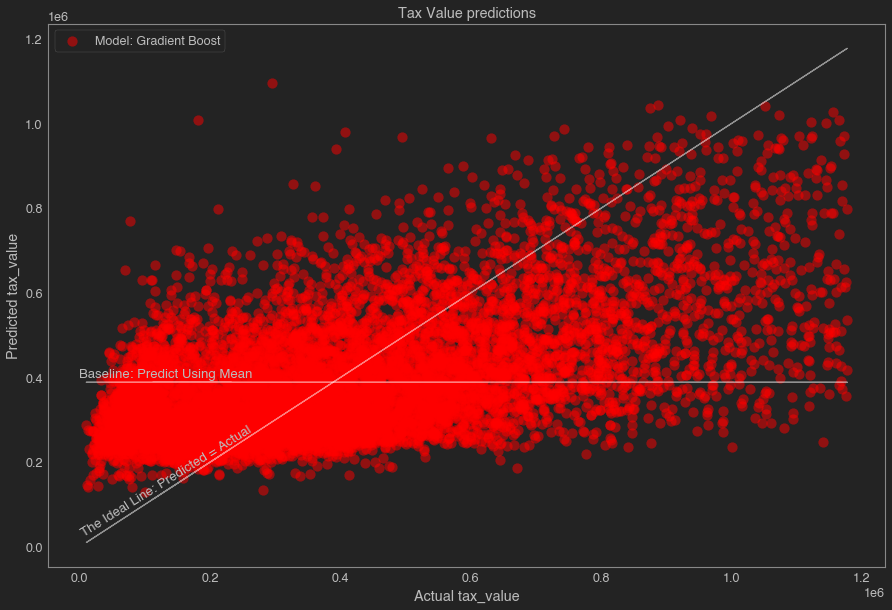

In [813]:
jtplot.style(grid='False')
plt.figure(figsize=(15,10))
plt.plot(y_validate_mod.tax_value, y_validate_mod.tax_pred_mean, alpha=.5, color="white", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (0.5, 400000))
plt.plot(y_validate_mod.tax_value, y_validate_mod.tax_value, alpha=.5, color="white", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 25000), rotation=32)

plt.scatter(y_validate_mod.tax_value, y_validate_mod.tax_pred_gbr, 
            alpha=.5, color="red", s=100, label="Model: Gradient Boost")

plt.legend()
plt.xlabel("Actual tax_value")
plt.ylabel("Predicted tax_value")
plt.title("Tax Value predictions")

plt.show()

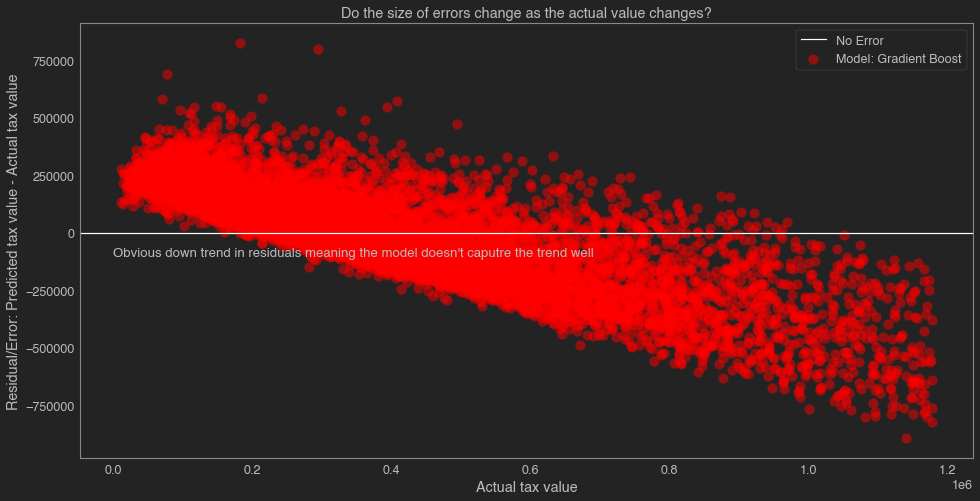

In [814]:
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate_mod.tax_value, y_validate_mod.tax_pred_gbr-y_validate_mod.tax_value, 
            alpha=.5, color="red", s=100, label="Model: Gradient Boost")

plt.legend()
plt.xlabel("Actual tax value")
plt.ylabel("Residual/Error: Predicted tax value - Actual tax value")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("Obvious down trend in residuals meaning the model doesn't caputre the trend well", (2.0, -100000))

plt.show()

# Key Takeaways
- Not enough data within 4 month time period for a reliable regression model
- Square footage, age, bed and bathrooms are the key drivers
- Possibly need more exploration and the previous year's data for the same time period to improve